In [1]:
import numpy as np
import xarray as xr
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import *
import tensorflow.keras.backend as K
import itertools
from tensorflow.keras.utils import to_categorical
from src.score import *
import re
from collections import OrderedDict

import sys
print("Script name ", sys.argv[0])

block_no = 5


#device_name = tf.test.gpu_device_name()
#if device_name != '/device:GPU:0':
#    raise SystemError('GPU device not found')
#print('Found GPU at: {}'.format(device_name))

 
DATADIR = '/rds/general/user/mc4117/home/WeatherBench/data/'

z500_valid = load_test_data(f'{DATADIR}geopotential_500', 'z')
t850_valid = load_test_data(f'{DATADIR}temperature_850', 't')
valid = xr.merge([z500_valid, t850_valid])

z = xr.open_mfdataset(f'{DATADIR}geopotential_500/*.nc', combine='by_coords')
t = xr.open_mfdataset(f'{DATADIR}temperature_850/*.nc', combine='by_coords').drop('level')

# For the data generator all variables have to be merged into a single dataset.
datasets = [z, t]
ds = xr.merge(datasets)

# In this notebook let's only load a subset of the training data
ds_train = ds.sel(time=slice('1979', '2016'))  
ds_test = ds.sel(time=slice('2017', '2018'))

class DataGenerator(keras.utils.Sequence):
    def __init__(self, ds, var_dict, lead_time, batch_size=32, shuffle=True, load=True, mean=None, std=None, bins_z = None):
        """
        Data generator for WeatherBench data.
        Template from https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
        Args:
            ds: Dataset containing all variables
            var_dict: Dictionary of the form {'var': level}. Use None for level if data is of single level
            lead_time: Lead time in hours
            batch_size: Batch size
            shuffle: bool. If True, data is shuffled.
            load: bool. If True, datadet is loaded into RAM.
            mean: If None, compute mean from data.
            std: If None, compute standard deviation from data.
        """
        self.ds = ds
        self.var_dict = var_dict
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.lead_time = lead_time

        data = []
        generic_level = xr.DataArray([1], coords={'level': [1]}, dims=['level'])
        for var, levels in var_dict.items():
            try:
                data.append(ds[var].sel(level=levels))
            except ValueError:
                data.append(ds[var].expand_dims({'level': generic_level}, 1))

        self.data = xr.concat(data, 'level').transpose('time', 'lat', 'lon', 'level')
        self.mean = self.data.mean(('time', 'lat', 'lon')).compute() if mean is None else mean
        self.std = self.data.std('time').mean(('lat', 'lon')).compute() if std is None else std
        # Normalize
        self.data = (self.data - self.mean) / self.std
        self.n_samples = self.data.isel(time=slice(0, -lead_time)).shape[0]
        self.init_time = self.data.isel(time=slice(None, -lead_time)).time
        self.valid_time = self.data.isel(time=slice(lead_time, None)).time
        
        self.bins_z = np.linspace(ds.z.min(), ds.z.max(), 100) if bins_z is None else bins_z

        self.binned_data = xr.DataArray(np.digitize(ds.z, self.bins_z)-1, dims=['time', 'lat', 'lon'], coords={'time':self.data.time.values, 'lat': self.data.lat.values, 'lon': self.data.lon.values})

        del ds
        self.on_epoch_end()

        # For some weird reason calling .load() earlier messes up the mean and std computations
        if load: print('Loading data into RAM'); self.data.load()
        if load: print('Loading data into RAM'); self.binned_data.load()            

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.ceil(self.n_samples / self.batch_size))

    def __getitem__(self, i):
        'Generate one batch of data'
        idxs = self.idxs[i * self.batch_size:(i + 1) * self.batch_size]
        X = self.data.isel(time=idxs).values
        y = self.binned_data.isel(time=idxs + self.lead_time).values
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.idxs = np.arange(self.n_samples)
        if self.shuffle == True:
            np.random.shuffle(self.idxs)
            
# then we need a dictionary for all the variables and levels we want to extract from the dataset
dic = OrderedDict({'z': None, 't': None})

bs=32
lead_time=72

# Create a training and validation data generator. Use the train mean and std for validation as well.
dg_train = DataGenerator(
    ds_train.sel(time=slice('1979', '2015')), dic, lead_time, batch_size=bs, load=True)

dg_valid = DataGenerator(
    ds_train.sel(time=slice('2016', '2016')), dic, lead_time, batch_size=bs, mean=dg_train.mean, std=dg_train.std, bins_z = dg_train.bins_z, shuffle=False)

dg_test = DataGenerator(
    ds_test, dic, lead_time, batch_size=bs, mean=dg_train.mean, std=dg_train.std, bins_z = dg_train.bins_z, shuffle=False)

class PeriodicPadding2D(tf.keras.layers.Layer):
    def __init__(self, pad_width, **kwargs):
        super().__init__(**kwargs)
        self.pad_width = pad_width

    def call(self, inputs, **kwargs):
        if self.pad_width == 0:
            return inputs
        inputs_padded = tf.concat(
            [inputs[:, :, -self.pad_width:, :], inputs, inputs[:, :, :self.pad_width, :]], axis=2)
        # Zero padding in the lat direction
        inputs_padded = tf.pad(inputs_padded, [[0, 0], [self.pad_width, self.pad_width], [0, 0], [0, 0]])
        return inputs_padded

    def get_config(self):
        config = super().get_config()
        config.update({'pad_width': self.pad_width})
        return config


class PeriodicConv2D(tf.keras.layers.Layer):
    def __init__(self, filters,
                 kernel_size,
                 conv_kwargs={},
                 **kwargs, ):
        super().__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.conv_kwargs = conv_kwargs
        if type(kernel_size) is not int:
            assert kernel_size[0] == kernel_size[1], 'PeriodicConv2D only works for square kernels'
            kernel_size = kernel_size[0]
        pad_width = (kernel_size - 1) // 2
        self.padding = PeriodicPadding2D(pad_width)
        self.conv = Conv2D(
            filters, kernel_size, padding='valid', dtype = 'float32', **conv_kwargs
        )

    def call(self, inputs):
        return self.conv(self.padding(inputs))

    def get_config(self):
        config = super().get_config()
        config.update({'filters': self.filters, 'kernel_size': self.kernel_size, 'conv_kwargs': self.conv_kwargs})
        return config
    
def convblock(inputs, f, k, l2, dr = 0):
    x = inputs
    if l2 is not None:
        x = PeriodicConv2D(f, k, conv_kwargs={
            'kernel_regularizer': keras.regularizers.l2(l2)})(x) 
    else:
        x = PeriodicConv2D(f, k)(x)
    x = LeakyReLU(dtype = "float32")(x)
    x = BatchNormalization(dtype = "float32")(x)
    if dr>0: x = Dropout(dr, dtype = "float32")(x, training = True)

    return x

def build_resnet_cnn(filters, kernels, input_shape, l2 = None, dr = 0, skip = True):
    """Fully convolutional residual network"""

    x = input = keras.layers.Input(shape=input_shape)
    x = convblock(x, filters[0], kernels[0], dr)

    #Residual blocks
    for f, k in zip(filters[1:-1], kernels[1:-1]):
        y = x
        for _ in range(2):
            x = convblock(x, f, k, l2, dr)
        if skip: x = Add()([y, x])
    out = Reshape((32*64, 100), input_shape = (32, 64, 100))(x)
    out = Activation('softmax')(out)
    out = Reshape((32, 64, 100), input_shape = (32*64, 100))(out)
   
    return keras.models.Model(input, out)


Script name  /rds/general/user/mc4117/home/anaconda3/envs/test2/lib/python3.6/site-packages/ipykernel_launcher.py
Loading data into RAM
Loading data into RAM
Loading data into RAM
Loading data into RAM
Loading data into RAM
Loading data into RAM


In [2]:
block_no = 5
filt = [100]
kern = [5]

for i in range(int(block_no)):
    filt.append(100)
    kern.append(5)

filt.append(1)
kern.append(5)

cnn = build_resnet_cnn(filt, kern, (32, 64, 2), l2 = 1e-5, dr = 0.1)
print(cnn.summary())

cnn.compile(keras.optimizers.Adam(5e-5), loss = 'sparse_categorical_crossentropy', metrics = ['sparse_categorical_accuracy'])

print(cnn.summary())

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
                        monitor='val_loss',
                        min_delta=0,
                        patience=5,
                        verbose=1, 
                        mode='auto'
                    )

reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
            monitor = 'val_loss',
            patience=2,
            factor=0.2,
            verbose=1)

"""
cnn.fit(dg_train, epochs=100, validation_data=dg_valid, callbacks=[early_stopping_callback, reduce_lr_callback])
"""

cnn.load_weights('/rds/general/user/mc4117/home/WeatherBench/saved_models/whole_cat_crossent_non_ohe_dr_' + str(block_no) + '.h5')



Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 64, 2)]  0                                            
__________________________________________________________________________________________________
periodic_conv2d (PeriodicConv2D (None, 32, 64, 100)  5100        input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 32, 64, 100)  0           periodic_conv2d[0][0]            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 64, 100)  400         leaky_re_lu[0][0]                
______________________________________________________________________________________________

In [13]:
no_of_forecasts = 3

for i in range(no_of_forecasts):
    print(i)
    bins_z_avg = [(dg_test.bins_z[i] + dg_test.bins_z[i+1])/2 for i in range(len(dg_test.bins_z)-1)]

    fc = cnn.predict(dg_test)

    fc_arg_avg = fc.argmax(axis = -1)

    for i in range(99):
        fc_arg_avg[fc_arg_avg == i] = bins_z_avg[i]

    fc_conv_ds_avg = xr.Dataset({
        'z': xr.DataArray(
              fc_arg_avg,
               dims=['time', 'lat', 'lon'],
               coords={'time':dg_test.data.time[72:], 'lat': dg_test.data.lat, 'lon': dg_test.data.lon,
                })})
    fc_all.append(fc_conv_ds_avg)


0
1
2


In [14]:
fc_avg = 0
rmse_list = []

for i in range(len(fc_all)):
    fc_avg += fc_all[i]
    cnn_rmse_arg = compute_weighted_rmse(fc_avg/(i+1), ds_test.z[72:]).compute()
    rmse_list.append(cnn_rmse_arg)

rmse_list

[<xarray.Dataset>
 Dimensions:  ()
 Coordinates:
     level    int32 500
 Data variables:
     z        float64 622.7, <xarray.Dataset>
 Dimensions:  ()
 Coordinates:
     level    int32 500
 Data variables:
     z        float64 562.7, <xarray.Dataset>
 Dimensions:  ()
 Coordinates:
     level    int32 500
 Data variables:
     z        float64 542.2, <xarray.Dataset>
 Dimensions:  ()
 Coordinates:
     level    int32 500
 Data variables:
     z        float64 531.1, <xarray.Dataset>
 Dimensions:  ()
 Coordinates:
     level    int32 500
 Data variables:
     z        float64 524.5, <xarray.Dataset>
 Dimensions:  ()
 Coordinates:
     level    int32 500
 Data variables:
     z        float64 520.2]

In [15]:
no_of_forecasts = 3

for i in range(no_of_forecasts):
    print(i)
    bins_z_avg = [(dg_test.bins_z[i] + dg_test.bins_z[i+1])/2 for i in range(len(dg_test.bins_z)-1)]

    fc = cnn.predict(dg_test)

    fc_arg_avg = fc.argmax(axis = -1)

    for i in range(99):
        fc_arg_avg[fc_arg_avg == i] = bins_z_avg[i]

    fc_conv_ds_avg = xr.Dataset({
        'z': xr.DataArray(
              fc_arg_avg,
               dims=['time', 'lat', 'lon'],
               coords={'time':dg_test.data.time[72:], 'lat': dg_test.data.lat, 'lon': dg_test.data.lon,
                })})
    fc_all.append(fc_conv_ds_avg)


0
1
2


In [16]:
fc_avg = 0
rmse_list = []

for i in range(len(fc_all)):
    fc_avg += fc_all[i]
    cnn_rmse_arg = compute_weighted_rmse(fc_avg/(i+1), ds_test.z[72:]).compute()
    rmse_list.append(cnn_rmse_arg)

rmse_list

[<xarray.Dataset>
 Dimensions:  ()
 Coordinates:
     level    int32 500
 Data variables:
     z        float64 622.7, <xarray.Dataset>
 Dimensions:  ()
 Coordinates:
     level    int32 500
 Data variables:
     z        float64 562.7, <xarray.Dataset>
 Dimensions:  ()
 Coordinates:
     level    int32 500
 Data variables:
     z        float64 542.2, <xarray.Dataset>
 Dimensions:  ()
 Coordinates:
     level    int32 500
 Data variables:
     z        float64 531.1, <xarray.Dataset>
 Dimensions:  ()
 Coordinates:
     level    int32 500
 Data variables:
     z        float64 524.5, <xarray.Dataset>
 Dimensions:  ()
 Coordinates:
     level    int32 500
 Data variables:
     z        float64 520.2, <xarray.Dataset>
 Dimensions:  ()
 Coordinates:
     level    int32 500
 Data variables:
     z        float64 516.9, <xarray.Dataset>
 Dimensions:  ()
 Coordinates:
     level    int32 500
 Data variables:
     z        float64 514.4, <xarray.Dataset>
 Dimensions:  ()
 Coordinates:
     le

In [17]:
no_of_forecasts = 3

for i in range(no_of_forecasts):
    print(i)
    bins_z_avg = [(dg_test.bins_z[i] + dg_test.bins_z[i+1])/2 for i in range(len(dg_test.bins_z)-1)]

    fc = cnn.predict(dg_test)

    fc_arg_avg = fc.argmax(axis = -1)

    for i in range(99):
        fc_arg_avg[fc_arg_avg == i] = bins_z_avg[i]

    fc_conv_ds_avg = xr.Dataset({
        'z': xr.DataArray(
              fc_arg_avg,
               dims=['time', 'lat', 'lon'],
               coords={'time':dg_test.data.time[72:], 'lat': dg_test.data.lat, 'lon': dg_test.data.lon,
                })})
    fc_all.append(fc_conv_ds_avg)


0
1
2


In [18]:
fc_avg = 0
rmse_list = []

for i in range(len(fc_all)):
    fc_avg += fc_all[i]
    cnn_rmse_arg = compute_weighted_rmse(fc_avg/(i+1), ds_test.z[72:]).compute()
    rmse_list.append(cnn_rmse_arg)

rmse_list

[<xarray.Dataset>
 Dimensions:  ()
 Coordinates:
     level    int32 500
 Data variables:
     z        float64 622.7, <xarray.Dataset>
 Dimensions:  ()
 Coordinates:
     level    int32 500
 Data variables:
     z        float64 562.7, <xarray.Dataset>
 Dimensions:  ()
 Coordinates:
     level    int32 500
 Data variables:
     z        float64 542.2, <xarray.Dataset>
 Dimensions:  ()
 Coordinates:
     level    int32 500
 Data variables:
     z        float64 531.1, <xarray.Dataset>
 Dimensions:  ()
 Coordinates:
     level    int32 500
 Data variables:
     z        float64 524.5, <xarray.Dataset>
 Dimensions:  ()
 Coordinates:
     level    int32 500
 Data variables:
     z        float64 520.2, <xarray.Dataset>
 Dimensions:  ()
 Coordinates:
     level    int32 500
 Data variables:
     z        float64 516.9, <xarray.Dataset>
 Dimensions:  ()
 Coordinates:
     level    int32 500
 Data variables:
     z        float64 514.4, <xarray.Dataset>
 Dimensions:  ()
 Coordinates:
     le

In [19]:
no_of_forecasts = 3

for i in range(no_of_forecasts):
    print(i)
    bins_z_avg = [(dg_test.bins_z[i] + dg_test.bins_z[i+1])/2 for i in range(len(dg_test.bins_z)-1)]

    fc = cnn.predict(dg_test)

    fc_arg_avg = fc.argmax(axis = -1)

    for i in range(99):
        fc_arg_avg[fc_arg_avg == i] = bins_z_avg[i]

    fc_conv_ds_avg = xr.Dataset({
        'z': xr.DataArray(
              fc_arg_avg,
               dims=['time', 'lat', 'lon'],
               coords={'time':dg_test.data.time[72:], 'lat': dg_test.data.lat, 'lon': dg_test.data.lon,
                })})
    fc_all.append(fc_conv_ds_avg)


0
1
2


In [20]:
fc_avg = 0
rmse_list = []

for i in range(len(fc_all)):
    fc_avg += fc_all[i]
    cnn_rmse_arg = compute_weighted_rmse(fc_avg/(i+1), ds_test.z[72:]).compute()
    rmse_list.append(cnn_rmse_arg)

rmse_list

[<xarray.Dataset>
 Dimensions:  ()
 Coordinates:
     level    int32 500
 Data variables:
     z        float64 622.7, <xarray.Dataset>
 Dimensions:  ()
 Coordinates:
     level    int32 500
 Data variables:
     z        float64 562.7, <xarray.Dataset>
 Dimensions:  ()
 Coordinates:
     level    int32 500
 Data variables:
     z        float64 542.2, <xarray.Dataset>
 Dimensions:  ()
 Coordinates:
     level    int32 500
 Data variables:
     z        float64 531.1, <xarray.Dataset>
 Dimensions:  ()
 Coordinates:
     level    int32 500
 Data variables:
     z        float64 524.5, <xarray.Dataset>
 Dimensions:  ()
 Coordinates:
     level    int32 500
 Data variables:
     z        float64 520.2, <xarray.Dataset>
 Dimensions:  ()
 Coordinates:
     level    int32 500
 Data variables:
     z        float64 516.9, <xarray.Dataset>
 Dimensions:  ()
 Coordinates:
     level    int32 500
 Data variables:
     z        float64 514.4, <xarray.Dataset>
 Dimensions:  ()
 Coordinates:
     le

In [21]:
no_of_forecasts = 3

for i in range(no_of_forecasts):
    print(i)
    bins_z_avg = [(dg_test.bins_z[i] + dg_test.bins_z[i+1])/2 for i in range(len(dg_test.bins_z)-1)]

    fc = cnn.predict(dg_test)

    fc_arg_avg = fc.argmax(axis = -1)

    for i in range(99):
        fc_arg_avg[fc_arg_avg == i] = bins_z_avg[i]

    fc_conv_ds_avg = xr.Dataset({
        'z': xr.DataArray(
              fc_arg_avg,
               dims=['time', 'lat', 'lon'],
               coords={'time':dg_test.data.time[72:], 'lat': dg_test.data.lat, 'lon': dg_test.data.lon,
                })})
    fc_all.append(fc_conv_ds_avg)


0
1
2


In [22]:
fc_avg = 0
rmse_list = []

for i in range(len(fc_all)):
    fc_avg += fc_all[i]
    cnn_rmse_arg = compute_weighted_rmse(fc_avg/(i+1), ds_test.z[72:]).compute()
    rmse_list.append(cnn_rmse_arg)

rmse_list

[<xarray.Dataset>
 Dimensions:  ()
 Coordinates:
     level    int32 500
 Data variables:
     z        float64 622.7, <xarray.Dataset>
 Dimensions:  ()
 Coordinates:
     level    int32 500
 Data variables:
     z        float64 562.7, <xarray.Dataset>
 Dimensions:  ()
 Coordinates:
     level    int32 500
 Data variables:
     z        float64 542.2, <xarray.Dataset>
 Dimensions:  ()
 Coordinates:
     level    int32 500
 Data variables:
     z        float64 531.1, <xarray.Dataset>
 Dimensions:  ()
 Coordinates:
     level    int32 500
 Data variables:
     z        float64 524.5, <xarray.Dataset>
 Dimensions:  ()
 Coordinates:
     level    int32 500
 Data variables:
     z        float64 520.2, <xarray.Dataset>
 Dimensions:  ()
 Coordinates:
     level    int32 500
 Data variables:
     z        float64 516.9, <xarray.Dataset>
 Dimensions:  ()
 Coordinates:
     level    int32 500
 Data variables:
     z        float64 514.4, <xarray.Dataset>
 Dimensions:  ()
 Coordinates:
     le

In [23]:
no_of_forecasts = 3

for i in range(no_of_forecasts):
    print(i)
    bins_z_avg = [(dg_test.bins_z[i] + dg_test.bins_z[i+1])/2 for i in range(len(dg_test.bins_z)-1)]

    fc = cnn.predict(dg_test)

    fc_arg_avg = fc.argmax(axis = -1)

    for i in range(99):
        fc_arg_avg[fc_arg_avg == i] = bins_z_avg[i]

    fc_conv_ds_avg = xr.Dataset({
        'z': xr.DataArray(
              fc_arg_avg,
               dims=['time', 'lat', 'lon'],
               coords={'time':dg_test.data.time[72:], 'lat': dg_test.data.lat, 'lon': dg_test.data.lon,
                })})
    fc_all.append(fc_conv_ds_avg)


0
1
2


In [24]:
fc_avg = 0
rmse_list = []

for i in range(len(fc_all)):
    fc_avg += fc_all[i]
    cnn_rmse_arg = compute_weighted_rmse(fc_avg/(i+1), ds_test.z[72:]).compute()
    rmse_list.append(cnn_rmse_arg)

rmse_list

[<xarray.Dataset>
 Dimensions:  ()
 Coordinates:
     level    int32 500
 Data variables:
     z        float64 622.7, <xarray.Dataset>
 Dimensions:  ()
 Coordinates:
     level    int32 500
 Data variables:
     z        float64 562.7, <xarray.Dataset>
 Dimensions:  ()
 Coordinates:
     level    int32 500
 Data variables:
     z        float64 542.2, <xarray.Dataset>
 Dimensions:  ()
 Coordinates:
     level    int32 500
 Data variables:
     z        float64 531.1, <xarray.Dataset>
 Dimensions:  ()
 Coordinates:
     level    int32 500
 Data variables:
     z        float64 524.5, <xarray.Dataset>
 Dimensions:  ()
 Coordinates:
     level    int32 500
 Data variables:
     z        float64 520.2, <xarray.Dataset>
 Dimensions:  ()
 Coordinates:
     level    int32 500
 Data variables:
     z        float64 516.9, <xarray.Dataset>
 Dimensions:  ()
 Coordinates:
     level    int32 500
 Data variables:
     z        float64 514.4, <xarray.Dataset>
 Dimensions:  ()
 Coordinates:
     le

In [25]:
no_of_forecasts = 3

for i in range(no_of_forecasts):
    print(i)
    bins_z_avg = [(dg_test.bins_z[i] + dg_test.bins_z[i+1])/2 for i in range(len(dg_test.bins_z)-1)]

    fc = cnn.predict(dg_test)

    fc_arg_avg = fc.argmax(axis = -1)

    for i in range(99):
        fc_arg_avg[fc_arg_avg == i] = bins_z_avg[i]

    fc_conv_ds_avg = xr.Dataset({
        'z': xr.DataArray(
              fc_arg_avg,
               dims=['time', 'lat', 'lon'],
               coords={'time':dg_test.data.time[72:], 'lat': dg_test.data.lat, 'lon': dg_test.data.lon,
                })})
    fc_all.append(fc_conv_ds_avg)


0
1
2


In [26]:
fc_avg = 0
rmse_list = []

for i in range(len(fc_all)):
    fc_avg += fc_all[i]
    cnn_rmse_arg = compute_weighted_rmse(fc_avg/(i+1), ds_test.z[72:]).compute()
    rmse_list.append(cnn_rmse_arg)

rmse_list

[<xarray.Dataset>
 Dimensions:  ()
 Coordinates:
     level    int32 500
 Data variables:
     z        float64 622.7, <xarray.Dataset>
 Dimensions:  ()
 Coordinates:
     level    int32 500
 Data variables:
     z        float64 562.7, <xarray.Dataset>
 Dimensions:  ()
 Coordinates:
     level    int32 500
 Data variables:
     z        float64 542.2, <xarray.Dataset>
 Dimensions:  ()
 Coordinates:
     level    int32 500
 Data variables:
     z        float64 531.1, <xarray.Dataset>
 Dimensions:  ()
 Coordinates:
     level    int32 500
 Data variables:
     z        float64 524.5, <xarray.Dataset>
 Dimensions:  ()
 Coordinates:
     level    int32 500
 Data variables:
     z        float64 520.2, <xarray.Dataset>
 Dimensions:  ()
 Coordinates:
     level    int32 500
 Data variables:
     z        float64 516.9, <xarray.Dataset>
 Dimensions:  ()
 Coordinates:
     level    int32 500
 Data variables:
     z        float64 514.4, <xarray.Dataset>
 Dimensions:  ()
 Coordinates:
     le

In [28]:
no_of_forecasts = 3

for i in range(no_of_forecasts):
    print(i)
    bins_z_avg = [(dg_test.bins_z[i] + dg_test.bins_z[i+1])/2 for i in range(len(dg_test.bins_z)-1)]

    fc = cnn.predict(dg_test)

    fc_arg_avg = fc.argmax(axis = -1)

    for i in range(99):
        fc_arg_avg[fc_arg_avg == i] = bins_z_avg[i]

    fc_conv_ds_avg = xr.Dataset({
        'z': xr.DataArray(
              fc_arg_avg,
               dims=['time', 'lat', 'lon'],
               coords={'time':dg_test.data.time[72:], 'lat': dg_test.data.lat, 'lon': dg_test.data.lon,
                })})
    fc_all.append(fc_conv_ds_avg)


0
1
2


In [29]:
fc_avg = 0
rmse_list = []

for i in range(len(fc_all)):
    fc_avg += fc_all[i]
    cnn_rmse_arg = compute_weighted_rmse(fc_avg/(i+1), ds_test.z[72:]).compute()
    rmse_list.append(cnn_rmse_arg)

rmse_list

[<xarray.Dataset>
 Dimensions:  ()
 Coordinates:
     level    int32 500
 Data variables:
     z        float64 622.7, <xarray.Dataset>
 Dimensions:  ()
 Coordinates:
     level    int32 500
 Data variables:
     z        float64 562.7, <xarray.Dataset>
 Dimensions:  ()
 Coordinates:
     level    int32 500
 Data variables:
     z        float64 542.2, <xarray.Dataset>
 Dimensions:  ()
 Coordinates:
     level    int32 500
 Data variables:
     z        float64 531.1, <xarray.Dataset>
 Dimensions:  ()
 Coordinates:
     level    int32 500
 Data variables:
     z        float64 524.5, <xarray.Dataset>
 Dimensions:  ()
 Coordinates:
     level    int32 500
 Data variables:
     z        float64 520.2, <xarray.Dataset>
 Dimensions:  ()
 Coordinates:
     level    int32 500
 Data variables:
     z        float64 516.9, <xarray.Dataset>
 Dimensions:  ()
 Coordinates:
     level    int32 500
 Data variables:
     z        float64 514.4, <xarray.Dataset>
 Dimensions:  ()
 Coordinates:
     le

In [30]:
no_of_forecasts = 3

for i in range(no_of_forecasts):
    print(i)
    bins_z_avg = [(dg_test.bins_z[i] + dg_test.bins_z[i+1])/2 for i in range(len(dg_test.bins_z)-1)]

    fc = cnn.predict(dg_test)

    fc_arg_avg = fc.argmax(axis = -1)

    for i in range(99):
        fc_arg_avg[fc_arg_avg == i] = bins_z_avg[i]

    fc_conv_ds_avg = xr.Dataset({
        'z': xr.DataArray(
              fc_arg_avg,
               dims=['time', 'lat', 'lon'],
               coords={'time':dg_test.data.time[72:], 'lat': dg_test.data.lat, 'lon': dg_test.data.lon,
                })})
    fc_all.append(fc_conv_ds_avg)


0
1
2


In [31]:
fc_avg = 0
rmse_list = []

for i in range(len(fc_all)):
    fc_avg += fc_all[i]
    cnn_rmse_arg = compute_weighted_rmse(fc_avg/(i+1), ds_test.z[72:]).compute()
    rmse_list.append(cnn_rmse_arg)

rmse_list

[<xarray.Dataset>
 Dimensions:  ()
 Coordinates:
     level    int32 500
 Data variables:
     z        float64 622.7, <xarray.Dataset>
 Dimensions:  ()
 Coordinates:
     level    int32 500
 Data variables:
     z        float64 562.7, <xarray.Dataset>
 Dimensions:  ()
 Coordinates:
     level    int32 500
 Data variables:
     z        float64 542.2, <xarray.Dataset>
 Dimensions:  ()
 Coordinates:
     level    int32 500
 Data variables:
     z        float64 531.1, <xarray.Dataset>
 Dimensions:  ()
 Coordinates:
     level    int32 500
 Data variables:
     z        float64 524.5, <xarray.Dataset>
 Dimensions:  ()
 Coordinates:
     level    int32 500
 Data variables:
     z        float64 520.2, <xarray.Dataset>
 Dimensions:  ()
 Coordinates:
     level    int32 500
 Data variables:
     z        float64 516.9, <xarray.Dataset>
 Dimensions:  ()
 Coordinates:
     level    int32 500
 Data variables:
     z        float64 514.4, <xarray.Dataset>
 Dimensions:  ()
 Coordinates:
     le

In [32]:
len(rmse_list)

30

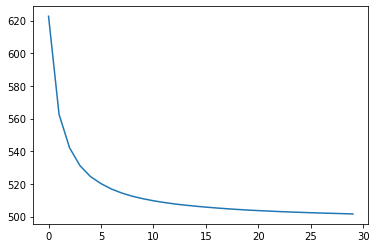

In [34]:
import pylab as plt
plt.plot([i.z for i in rmse_list])